In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import edward as ed
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from edward.models import Categorical, Normal, StudentT, Dirichlet, InverseGamma, ParamMixture, MultivariateNormalDiag

import pandas as pd
import seaborn as sns
%matplotlib inline

%load_ext autoreload

import sys
sys.path.insert(0, tf.__path__[0] + '/contrib/distributions/python/ops')

import bijectors as bijector
ds = tf.contrib.distributions


try:
    from tensorflow.contrib.distributions import FULLY_REPARAMETERIZED
except Exception as e:
    raise ImportError("{0}. Your TensorFlow version is not supported.".format(e))

ImportError: cannot import name set_shapes_for_outputs

In [2]:
def mixtureOfGaussians(N = 100, D=2, K=2):
    """
    Explicit latent variables for the mixture assignments (as opposed to the collapsed version with assigments marginalized)
    """
    pi = Dirichlet(tf.ones(K))
    mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
    sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
    x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                     MultivariateNormalDiag,
                     sample_shape=N)
    z = x.cat
    return (pi,mu,sigmasq,z,x)

In [125]:
K = 3
D = 1
pi = Dirichlet(tf.ones(K))
z = Categorical(probs=pi)
sigmasq = InverseGamma(tf.ones([D]), tf.ones([D]), sample_shape=K)
x = ds.MixtureSameFamily(mixture_distribution=z,components_distribution=Normal(loc=tf.zeros([3]),scale=tf.sqrt(sigmasq)))

In [129]:
z.sample().eval()

0

In [127]:
x.sample()

<tf.Tensor 'MixtureSameFamily_37/sample/Reshape:0' shape=(3,) dtype=float32>

In [183]:
K = 2
pi = Dirichlet(tf.ones([K]))
z = Categorical(probs=pi)
sigmasq = InverseGamma(tf.ones([K]), tf.ones([K]))
x = ds.MixtureSameFamily(mixture_distribution=z,components_distribution=Normal(loc=tf.zeros([K]),scale=tf.sqrt(sigmasq)))

In [184]:
x.sample().eval()

-1.6942041

In [ ]:
class newNormal(Distribution):
	def __init__(self,params,validate_args=False,allow_nan_stats=True,name="newNormal"):
		parameters = locals()
		with tf.name_scope(name, values=[params]):
			with tf.control_dependencies([]):
				self._params = tf.identity(params, name="params")
				try:
					self._n = tf.shape(self._params)[0]
				except ValueError:  # scalar params
					self._n = tf.constant(1)
		
		super(newNormal, self).__init__(
			dtype=self._params.dtype,
			reparameterization_type=FULLY_REPARAMETERIZED,
			validate_args=validate_args,
			allow_nan_stats=allow_nan_stats,
			parameters=parameters,
			graph_parents=[self._params, self._n],
			name=name)

	@staticmethod
	def _param_shapes(sample_shape):
		return {"params": tf.convert_to_tensor(sample_shape, dtype=tf.int32)}

	@property
	def params(self):
		"""Distribution parameter."""
		return self._params

	@property
	def n(self):
		"""Number of samples."""
		return self._n
	
	def _log_prob(self, value):
		raise NotImplementedError("log_prob is not implemented")

	def _sample_n(self, n, seed=None):
		input_tensor = self.params
		r = Uniform(low=input_tensor[0],high=input_tensor[1])._sample_n(n, seed)
		b = Uniform(low=0.0,high=6.283185)._sample_n(n, seed)
		x = tf.sqrt(r)*tf.cos(b)
		y = tf.sqrt(r)*tf.sin(b)
		z = Normal(loc=input_tensor[2],scale=input_tensor[3])._sample_n(n, seed)
		return tf.stack([x, y, z], axis=1)

In [4]:
from edward.models import RandomVariable
from tensorflow.contrib.distributions import Distribution

class MixtureOfUnivariateNormal(RandomVariable, Distribution):
    def __init__(self, params,validate_args=False,allow_nan_stats=True,name="MixtureOfUnivariateNormal"):
        parameters = locals()
        with tf.name_scope(name, values=[params]):
            with tf.control_dependencies([]):
                self._params = tf.identity(params, name="params")
            try:
                self._n = tf.shape(self._params)[0]
            except ValueError:  # scalar params
                self._n = tf.constant(1)
        super(MixtureOfUnivariateNormal, self).__init__(
            dtype=self._params.dtype,
            reparameterization_type=FULLY_REPARAMETERIZED,
            validate_args=validate_args,
            allow_nan_stats=allow_nan_stats,
            parameters=parameters,
            graph_parents=[self._params, self._n],
            name=name)
    
    @staticmethod
    def _param_shapes(sample_shape):
        return {"params": tf.convert_to_tensor(sample_shape, dtype=tf.int32)}

    @property
    def params(self):
        """Distribution parameter."""
        return self._params

    @property
    def n(self):
        """Number of samples."""
        return self._n

    def _log_prob(self, value):
        raise NotImplementedError("log_prob is not implemented")  

    def _sample_n(self, n, seed=None):
        input_tensor = self.params #K
        K = input_tensor[1]
        pi = Dirichlet(tf.ones([K]))
        z = Categorical(probs=pi)
        sigmasq = InverseGamma(tf.ones([K]), tf.ones([K]))
        x = ds.MixtureSameFamily(mixture_distribution=z,components_distribution=Normal(loc=tf.zeros([K]),scale=tf.sqrt(sigmasq)))
        return x._sample_n(n, seed)

In [5]:
mog = MixtureOfUnivariateNormal([10,3,2,5])

In [27]:
?ed.models.ParamMixture

In [6]:
mog.n.eval()

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [14]:
some_normals = Normal(loc=[0.,10.,-8.],scale=[1.,1.,10.])

In [22]:
some_normal_samples = some_normals.sample(1000).eval()

In [23]:
some_normal_samples.shape

(1000, 3)

(array([  2.,   3.,   5.,  10.,  18.,  27.,  42.,  56.,  56.,  88.,  94.,
        106.,  93.,  99.,  79.,  74.,  58.,  35.,  22.,  10.,   9.,   5.,
          4.,   3.,   1.,   1.]),
 array([-38.25693512, -35.72866821, -33.20040131, -30.6721344 ,
        -28.14386749, -25.61560059, -23.08733368, -20.55906677,
        -18.03079987, -15.50253296, -12.97426605, -10.44599915,
         -7.91773224,  -5.38946533,  -2.86119843,  -0.33293152,
          2.19533539,   4.72360229,   7.2518692 ,   9.78013611,
         12.30840302,  14.83666992,  17.36493683,  19.89320374,
         22.42147064,  24.94973755,  27.47800446]),
 <a list of 26 Patch objects>)

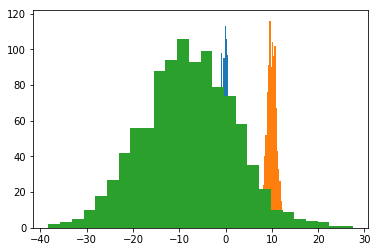

In [25]:
plt.hist(some_normal_samples[:,0],'auto')
plt.hist(some_normal_samples[:,1],'auto')
plt.hist(some_normal_samples[:,2],'auto')

In [10]:
sess = ed.get_session()
mog_sample = mog.sample((1000,3)).eval()

In [11]:
mog_sample.shape

(1000, 3)

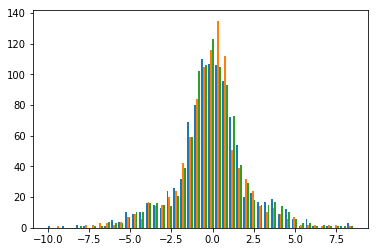

In [12]:
plt.hist(mog_sample,'auto');

In [15]:
mog1 = mixtureOfGaussians(N=100,D=2,K=3)

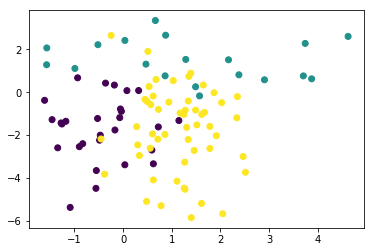

In [6]:
sess = ed.get_session()
mog1_sample = sess.run([v.value() for v in mog1]) # ancestral sampling

pi_true,mu_true,sigmasq_true,z_true,x_true = mog1_sample
# plot means
# plt.scatter(*mu_true.T,s=300)
# plot observation color coded by assignments
plt.scatter(*x_true.T, c=z_true)

In [9]:
def independentFactorAnalyzer(M=100,D=2,K=1,tau=1.,lamda=20.):
    lamda = lamda*tf.ones([K])
    sigma = ed.models.Gamma(tf.ones([D]),tf.ones([D]))
    w = Normal(tf.zeros([D, K]),    tf.reshape(tf.tile(np.abs(tau)*np.abs(lamda),[D]),[D,K]))
    pi_source,mu_source,sigmasq_source,z_assignments_source,x_source = mixtureOfGaussians(N=M,D=1,K=K)
    z = x_source
    mu = Normal(tf.zeros([D]),tf.ones([D]))
    x = MultivariateNormalDiag(tf.add(tf.transpose(tf.matmul(w, z, transpose_b=True)),mu), tf.reshape(tf.tile(sigma,[M]),[M,D]))
    return (pi_source,mu_source,sigmasq_source,z_assignments_source,w,z,mu,sigma,x)

In [10]:
ifa1 = independentFactorAnalyzer(M=1000,D=2,K=3)

In [ ]:
sess = ed.get_session()
ifa1_sample = sess.run([v.value() for v in ifa1]) # ancestral sampling

pi_source,mu_source,sigmasq_source,z_assignments_source,w,z,mu,sigma,x = mog1_sample